# Prerequisites for all figures

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numpy.random import default_rng
rng = default_rng()

In [2]:
def U(A, N=None): # unevenness U
    # from matrix A(x1,x2,...,y), compute D-1-matrix M(x1,x2,...)
    # of diversity indices of A along the xs distributions of ys
    # Input boolean N (x1,x2,...) where A is nonzero
    # to compute diversity index with observed elements and not the known total number of elements
# Normalize A where not all zeros
    B = np.sum(A, axis = len(A.shape)-1)[...,None]
    B[B==0] = 1
    A = A / B
# Shannon index
    A[A==0] = 1 # prepare cancelling of all absent species under the log
    HH = -np.sum( A * np.log(A) , axis = len(A.shape)-1)
    if N is None:
        B = np.count_nonzero(A - 1, axis=len(A.shape)-1)[...,None]
        B[B==0] = np.exp(1)
        HH = HH / np.log(B[...,0])
        return np.abs(1-HH)
    else:
        return np.abs(HH)

In [3]:
# finds a range of MPCs with metrics satisfying the provided targets
def setupMPCs(nelms=np.array([10], dtype=np.int16), nstps=10, targets=None,
              metric=U,
              iterate=1000, # nb iterations to optimize the setups
              nprelim=10, # nb of random samples for improvement for each iteration
             ):
    if targets is None:
        targets = np.array(range(nstps)) / nstps
    else:
        nstps = len(targets)
    gmax = np.max(nelms)
    setups = np.zeros( (nstps, nelms.shape[0], gmax) )
    mask = np.nonzero(targets)
    for i, g in enumerate(nelms):
        setups[:,i,:g] = 1 / g
    for i in range(iterate):
        array = np.ones((nstps, 1+nprelim, gmax))
        array[:,1:,:] += rng.uniform(size = (nstps, nprelim, gmax) )
        array = np.tile(setups[:,:,None,:], (1,1,nprelim+1,1)) * np.tile(array[:,None,:,:], (1,nelms.shape[0],1,1))
        idx = metric(array) # (nstps, nelms.shape[0], 1+nprelim)
        idx = np.abs(idx - targets[:,None,None]) # (nstps, nelms.shape[0], 1+nprelim)
        idx = idx.argmin(axis=-1) # (nstps, nelms.shape[0])
        for j in range(nstps):
            for k in range(nelms.shape[0]):
                setups[j,k,:] = array[j,k,idx[j,k],:]
        setups = setups / np.sum(setups, axis=-1)[...,None]
    return setups

# Main text figures

## Fig. 2

In [58]:
# nb sites for each gene in the SW25 setup
setup = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,], # top panel
                  [120, 50, 50, 10, 10, 85, 50, 10, 50, 50, 3, 3, 3, 2, 2, 2], # middle panel
                  [498, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], # bottom panel
                 ], dtype=np.half)
nametag = "16bis"
s = setup.shape[0] # nb setups
g = setup.shape[1] # nb genes/pathways
o = 5000 # nb of observations in an experiment = obs. span
x = 10000 # nb of experiments replicated

In [59]:
# SCALE to attribute each mutation to a gene
# = cumulated expected values for each gene, dims: (s, g)
scale = np.cumsum(setup, axis=1) / np.sum(setup, axis=1)[:,None]

stcnt = np.zeros((s, o), dtype=np.intc)
np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

In [72]:
# Matrix of completion experiment results
rslts = np.zeros((s, x)) # matrix to be filled
stcnt = np.zeros((s, x, o, g), dtype=np.intc) # site counts
# Updating rule
filtr = np.reshape(np.argmax(rng.uniform(size =(s, x, o))[:,:,:,None] < scale[:,None,None,:], axis=-1), (s,x,o))
# filter for stcnt, dims: (s, x, o, g) -> (s, x, o)
stcnt[np.tile(np.arange(s)[:,None,None], (1, x, o)),
      np.tile(np.arange(x)[None,:,None], (s, 1, o)),
      np.tile(np.arange(o)[None,None,:], (s, x, 1)),
      filtr] += 1
stcnt = np.cumsum(stcnt, axis=2) # dims: (s', x', o, g)
stcnt[np.tile((setup == 0)[:,None,None,:], (1,x,o,1))] = 1 # avoiding being counted as not-found when appearance is impossible
news = np.argmax(np.all(stcnt > 0, axis = -1) > 0, axis=-1) # reuse filtr for the total number to hit them all for each x, dims: (s, x)
rslts[news>0] = news[news>0]
if np.min(rslts) == 0:
    print("Uncompleted experiment(s) detected: increase observation span.")
else:
    xmax = np.max(rslts, axis=1)
    print("The longest experiments collected {} observations.".format(xmax))
    stcnt = np.count_nonzero(rslts[:,:,None] == (np.arange(o)+1)[None,None,:], axis=1)
    np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

The longest experiments collected [ 200. 2831. 2993.] observations.


In [75]:
counts = np.genfromtxt("CountsMPC{}.csv".format(nametag), delimiter=',').T
xs = np.array(range(counts.shape[1])) + 2
xmax = len(xs) - 2
nruns = np.sum(counts[0,:])

In [76]:
# Graphing parameters
scaling = 2 # scale / 10^scaling
xlim = 2000 # lim of the x-axis
quantiles = [0.5, 0.025, 0.975] # drawinglines for median and 95% range
qts = np.zeros(len(quantiles))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20

N = 9 # organizing the layout of the figure
n = 1

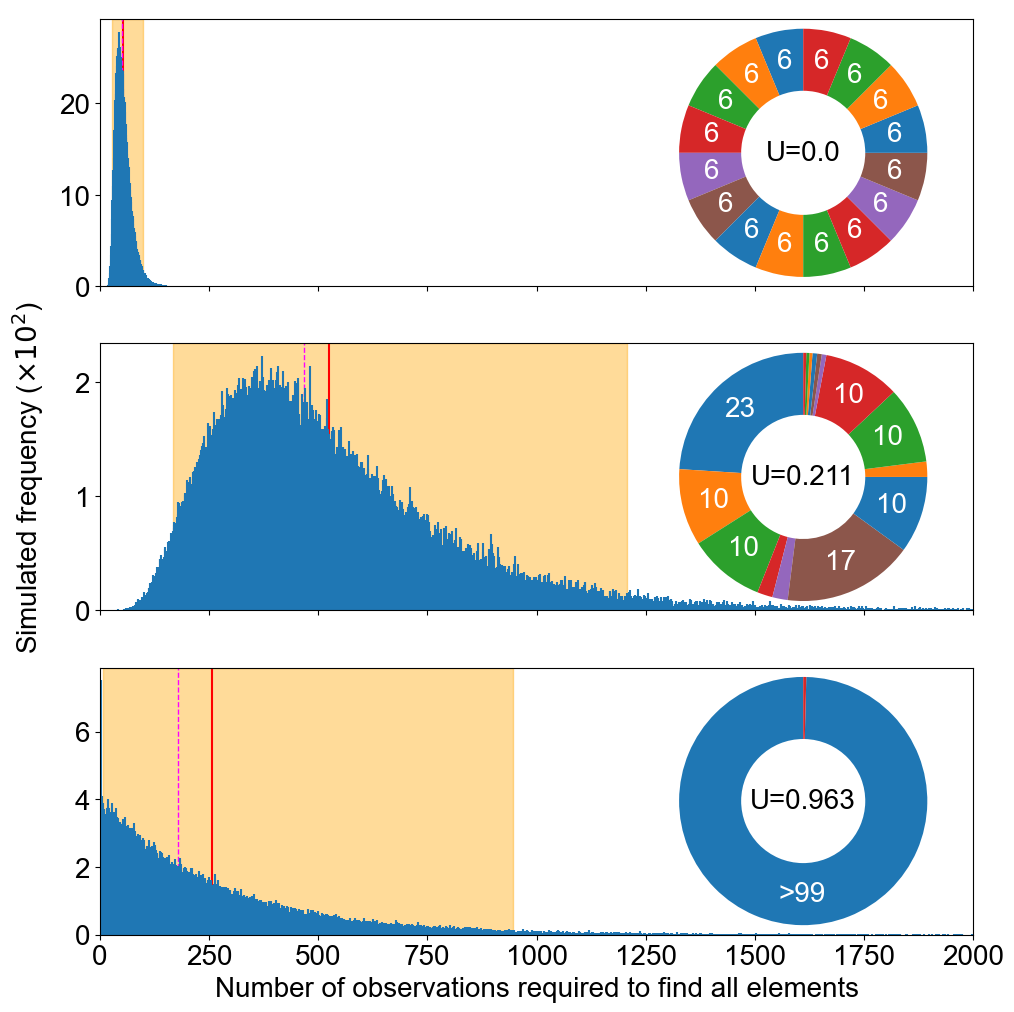

In [80]:
# Graph
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3*(N+n)-n, 5)

ax = fig.add_subplot(gs[:,:])
ax.tick_params(colors="None", top=False, bottom=False, left=False, right=False)
ax.set_xlabel("Number of observations required to find all elements")
ax.set_ylabel(r"Simulated frequency ($\times 10^{}$)".format(scaling) if scaling > 1 else r"Simulated frequency")
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

# Plotting each subfigure top to bottom
for i in range(3):
# Completion experiments
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, :])
    avgcount = np.sum(counts[i,:] * xs) / np.sum(counts[i,:]) # average count
    for j, qt in enumerate(quantiles): # quantiles
        qts[j] = (xs[np.nonzero( np.cumsum(counts[i,:]) > np.floor(nruns*qt) )][0]
                + xs[np.nonzero( np.cumsum(counts[i,:]) > np.ceil(nruns*qt) )][0]) / 2
    ax.axvline(x=avgcount, c="r")
    ax.axvline(x=qts[0], linestyle="dashed", c="magenta", linewidth=1,)
    ax.axvspan(qts[1], qts[2], color="orange", alpha=0.4, zorder=0)
    ax.vlines(xs, np.zeros(xs.shape), counts[i,:] / 10**scaling, zorder=2) # drawing the distribution of completion experiment results
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_ylim(0, np.max(counts[i,:] / 10**scaling) * 1.05)
    plt.xlim(0, xlim)
    if i < 2:
        plt.setp(ax.get_xticklabels(), visible=False)
# MPC of the setup-array
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, -2:])
    ax.pie(setup[i], startangle=90, shadow=False,
           colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',],
           autopct=lambda x: "" if np.around(x, 0) < 3 else "{}{}".format("" if x <=99 else ">", np.around(np.array(x, dtype=np.intc), 1)),
           pctdistance = 0.75, normalize=True, wedgeprops=dict(width=0.5), textprops = dict(color ="w"))
    ax.text(0., 0., "U={}".format(np.around(U(setup[i]), 3)), horizontalalignment='center', verticalalignment='center')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

### SAVING
name = "Fig2.pdf".format(nametag)
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 3

In [ ]:
def completion_experiments_on_a_random_MPC(g, Utarget, nexpm=100):
    setup = setupMPCs(np.array([g], dtype=np.int16), 1, targets=np.array([Utarget]), metric=U)[:,0,:]
    scale = np.cumsum(setup, axis=1) / np.sum(setup, axis=1)[:,None]
    clist = []
    for i in np.arange(nexpm):
        stcnt = np.zeros(g)
        while 0 in stcnt:
            stcnt[np.argmax(rng.uniform(size=(1)) < scale)] +=1
        clist += [np.sum(stcnt, dtype=int)]
    M = np.zeros(4)
    M[0] = np.mean(clist)
    M[1:] = np.quantile(clist, [0.025, 0.5, 0.975])
    return M

In [ ]:
# nb sites for each gene in the setup
gs = [16, 8, 4,] # nb genes/pathways
Utargets = np.arange(20) / 20 # U for the MPC in the middle panel

nMPCs = 100
qntls = np.zeros((20, nMPCs,4))

for g in gs:
    for j, Utarget in enumerate(Utargets):
#        print(Utarget)
        for i in np.arange(nMPCs):
            qntls[j,i,:] = completion_experiments_on_a_random_MPC(g=g, Utarget=Utarget, nexpm=100)
    np.savetxt("Fig3_{}.csv".format(g), np.median(qntls, axis=1), delimiter=",")

In [ ]:
qntls16 = np.genfromtxt("Fig3_16.csv", delimiter=',')
qntls8 = np.genfromtxt("Fig3_8.csv", delimiter=',')
qntls4 = np.genfromtxt("Fig3_4.csv", delimiter=',')

# Graph
fig = plt.figure(constrained_layout=True)
cs = ["b", "magenta", "r",]

gridspec = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gridspec[:,:])
for i, g in enumerate(gs):
    qntls = np.genfromtxt("Fig14_{}.csv".format(g), delimiter=',')
    c = cs[i]
    ax.fill_between(Utargets, qntls[:,1], qntls[:,3], color=c, alpha=0.1, zorder=1)
    ax.plot(Utargets, qntls[:,0], label="{}-MPC".format(g), c=c, zorder=2)
    ax.plot(Utargets, qntls[:,2], c=c, ls="dashed", zorder=3)

ax.legend(title="Number of mutations", loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, handlelength=2, handletextpad=0.5)

plt.yscale("log")
plt.xlabel("MPC-Unevenness")
plt.ylabel("Number of observations required for completion")
plt.xlim(0, 1)
plt.ylim(3, 3*10**4)

### SAVING
name = "Fig3.pdf"
plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 4

In [ ]:
# Parameters
nametag = "XXX"
g = 16 # nb of genes
nelms = np.array([g], dtype=np.int16) # nb of genes
nstps = 5 # nb of setups for each gene nb # 10

targets = np.arange(nstps) / nstps # target unevenness values U
targets = targets[1:] # targets[0] is trivially the equality situation where unevenness = 0

nexps = 10**4 # nb of experiments, where an experiment in a run observes one mutation in one site = time = nb observations
nruns = 10**2 # nb of runs, where a run counts mutations (nexps) until all mutation sites have been found = nb replicates

nprelim = 10 # nb samples for search for new tweeks
iterate = 100 # nb times updating closest unevenness after tweeking

In [19]:
# Randomly determining MPC-setups for target U values
setups = np.zeros( (nstps, nelms.shape[0], np.max(nelms)) )
for i, gg in enumerate(nelms):
    setups[:, i,:gg] = 1 / gg
    for j in range(iterate):
        array = np.ones((nprelim+1, gg))
        array[1:,:] += rng.uniform(size = (nprelim, gg) )
        array = np.tile(setups[None, 1:, i,:gg], (nprelim+1,1,1,)) * np.tile(array[:,None,:], (1, nstps-1, 1))
        G = U(array) # (10+1 x 9)
        for k, target in enumerate(targets, 1):
            idx = np.unravel_index(np.abs(G - target).argmin(axis=None), G.shape)
            setups[k,i,:gg] = array[idx] / np.sum(array[idx])[..., None]

array = setups[:,0,:] # (nstps x g)
G = U(array) # real unevenness: (nstps)

In [20]:
# setting up of the scale to locate each random sample in the pie
# Random sampling
scale = np.cumsum(array, axis=1) # SCALE to attribute each mutation to a gene = cumulated expected values for each gene
scale = np.repeat(scale[:,:,np.newaxis], nruns, axis=2) # scale: (nstps x g x nruns)

In [21]:
# Run numerical experiments
stcnt = np.zeros((nruns, nstps, g), dtype=np.intc) # site counter, registering for each mutation site the number of mutations counted, x nb of runs
Us = np.zeros((nruns, nstps, nexps)) # unevenness evaluated at each time step = each experiment

for i in range(nexps):
    MM = np.argmax(rng.uniform(size = (nruns) ) < scale[:,:,:], axis=1) # matrix w/indices for gene to increment: (nstps x nruns)
    stcnt[np.tile(np.arange(nruns), nstps), np.repeat(np.arange(nstps), nruns), np.ndarray.flatten(MM)] += 1
    Us[..., i] = U(stcnt) # register all new unevennesses at step i

In [22]:
# Computing values for curves
for i in np.arange(nstps):
    toplot = Us[:,i,:]- G[i]
    tosave = np.zeros((nexps, 4))
    tosave[:,0] = np.mean(toplot, axis=0)
    tosave[:,1] = np.quantile(toplot, 0.500, axis=0)
    tosave[:,2] = np.quantile(toplot, 0.025, axis=0)
    tosave[:,3] = np.quantile(toplot, 0.975, axis=0)
    np.savetxt("ConvergenceU{}_{}_{}.csv".format(np.around(G[i], 3), g, nametag), tosave, delimiter=",")

In [ ]:
# Graphing parameters
echelle = 0.3 # figure scale
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = [21.0 * echelle, 21.0 * echelle]
plt.rcParams['font.size'] = 12

tmax1 = 200 # tmax for the upper panel
tmax2 = 10000 # tmax for the lower panel
tmax = max(tmax1,tmax2)

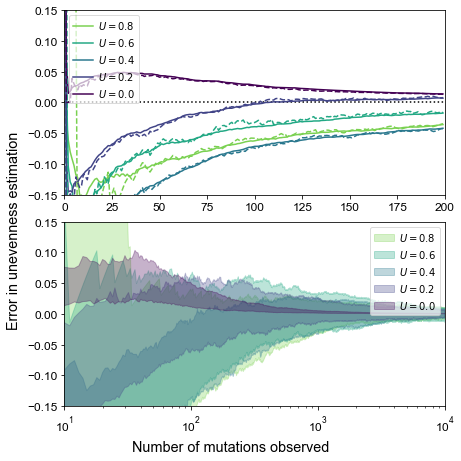

In [24]:
# Graph
fig = plt.figure(constrained_layout=True)
fig.supxlabel("Number of mutations observed")
fig.supylabel("Error in unevenness estimation")

gs = fig.add_gridspec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

cmap = plt.cm.get_cmap("viridis")

# Recursive plotting
for i in np.arange(nstps)[::-1]:
    tosave = np.genfromtxt("ConvergenceU{}_{}_{}.csv".format(np.around(G[i], 3), g, nametag), delimiter=',')
# UPPER PLOT
    ax1.plot(np.arange(nexps)[:tmax1], tosave[:tmax1,0], c=cmap(G[i]), zorder=1, ls="solid", label=r"$U = {}$".format( np.around(G[i], decimals=1)) )
    ax1.plot(np.arange(nexps)[:tmax1], tosave[:tmax1,1], c=cmap(G[i]), zorder=2, ls="dashed")
# LOWER PLOT
    ax2.fill_between(np.arange(nexps)[:tmax2], tosave[:tmax2,2], tosave[:tmax2,3], zorder=0,
                     color = cmap(G[i]), alpha = 0.3, # color and transparency
                     label=r"$U = {}$".format( np.around(G[i], decimals=1)), )

# Layout
ax1.plot(np.arange(nexps)[:tmax], np.zeros(tmax), c="k", zorder=0, ls="dotted")
ax1.legend(loc='best', fontsize='small', fancybox=True, framealpha=0.7, handlelength=2, handletextpad=0.5)
ax1.set_xlim(0, tmax1)
ax1.set_ylim(-0.15, 0.15)

ax2.legend(loc='best', fontsize='small', fancybox=True, framealpha=0.7,  handlelength=2, handletextpad=0.5)
ax2.set_xscale("log")
ax2.set_xlim(10, tmax2)
ax2.set_ylim(-0.15, 0.15)

### SAVING
name = "Fig4.pdf"
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 5

In [82]:
# cutoffs provided by the data
setup, dataname = [1,1,2,1,1,1,9,1,2,1,20,1], "Aws"

COs = U(np.array(setup)) # data cutoff value
setup = np.ones(len(setup))
selres = 0.95 # selection resolution, e.g. 95%

# exploration parameters
avg = 5 * 10**-11
logNsigmas = np.linspace(0.1, 7.1, 1 + 700) # exploration space for sigma
logNmus = np.log(avg) - logNsigmas**2 /2 # corresponding mu values

g = len(setup) # nb of genes
m = g # nb of mutation sites in total
s = 10**5 # nb of samples for sets of mutation rates # in the article: 10**7

In [83]:
# Result matrix to be filled
import scipy.stats
rslts = np.zeros((logNsigmas.shape[0], 2))
rslts[0,0] = 1

# exploration routine
for i, logNsigma in enumerate(logNsigmas):
    logNmu = logNmus[i]
    A = rng.normal(loc=logNmu, scale=logNsigma, size=(s,m) ) # all samples and all mutation rates (m,n)
    M = U(np.exp(A))
    kernel = scipy.stats.gaussian_kde(M)
    M = np.sort(M) >= COs
    S = np.sum(M)
    if S > 0 and S < s:
        rslts[i,0] = np.argmax(M) # rank from which CO is passed
    elif i > 0:
        rslts[i,0] = rslts[i-1,0]
    rslts[i,1] = kernel.evaluate(COs) # probability of CO in estimated distribution of selection means
rslts[:,0] /= s # normalization

In [84]:
# Interpretation in terms of a max-likelihood and a confidence interval

print("{} data with mean {} and sample size {}".format(dataname, avg, s))

lim = 50
maxLh = logNsigmas[np.argmax(rslts[:,1])]
CIinf = logNsigmas[np.argmax(rslts[:,0][lim:] < 0.5 + selres / 2) + lim-1]
CIsup = logNsigmas[np.argmax(rslts[:,0][lim:] < 0.5 - selres / 2) + lim]

print("Unevenness-Max-likelihood: sigma={}, CI = [{}, {}]".format(
    np.around(maxLh, 4),
    np.around(CIinf, 4),
    np.around(CIsup, 4),
))

Aws data with mean 4.9999999999999995e-11 and sample size 100000
Unevenness-Max-likelihood: sigma=1.76, CI = [0.93, 3.72]


In [85]:
# Graphing parameters
echelle = 0.3 # scale
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = [21.0 * echelle, 21.0 * echelle]
plt.rcParams['font.size'] = 12

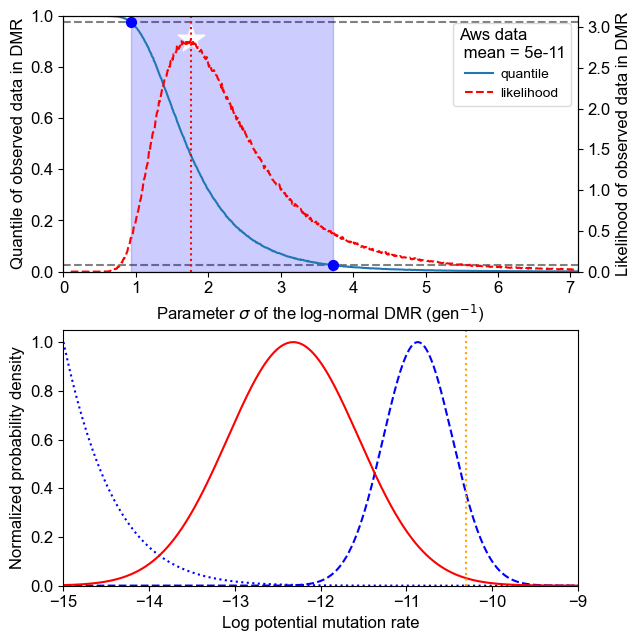

In [90]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 1)

# UPPER PLOT
ax = fig.add_subplot(gs[0, :])

# Plotting the quantile functions of the cutoff
ax.axhline(y=0.975, linestyle="dashed", c="grey", zorder=0)
ax.axhline(y=0.025, linestyle="dashed", c="grey", zorder=0)
lns1 = ax.plot(logNsigmas[lim:], rslts[lim:,0], label="quantile", zorder=2)
ax.scatter([CIinf, CIsup], [(1+selres)/2, (1-selres)/2], marker = "o", c="b", s=50, zorder=3)
ax.axvspan(CIinf, CIsup, color="b", alpha=0.2, zorder=1)

# Plotting the lifelihood functions of the cutoff
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
lns2 = ax2.plot(logNsigmas, rslts[:,1], label="likelihood", ls="dashed", c="r", zorder=2)
ax2.scatter(maxLh, np.max(rslts[:,1]), marker="*", c="w", s=400, zorder=1)
ax2.axvline(x=maxLh, linestyle="dotted", c="r", zorder=1)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, title="{} data \n mean = {}".format(dataname, np.around(avg, 11)), loc='best', fontsize='small', fancybox=True, framealpha=0.7, handlelength=2, handletextpad=0.5)

ax.set_xlim((0, logNsigmas[-1]))
ax.set_ylim((0, 1.0))
ax2.set_ylim((0, 1.1 * np.max(rslts[:,1]) ))
ax.set_xlabel(r"Parameter $\sigma$ of the log-normal DMR (gen$^{-1}$)")
ax.set_ylabel("Quantile of observed data in DMR")
ax2.set_ylabel("Likelihood of observed data in DMR")  # we already handled the x-label with ax1

# LOWER PLOT
ax = fig.add_subplot(gs[1, :])
sigmas = [CIinf, CIsup, maxLh]
c = ["b", "b", "r"]
ls = ["dashed", "dotted", "solid"]
xlims = (-15,-9)
x = np.linspace(xlims[0], xlims[1],1000)
# Recursive drawing of each distribution, for CIinf, CIsup and max-likelihood
for i, sigma in enumerate(sigmas):
    mu = np.log(avg) - sigma**2 / 2
    y = np.exp( - (np.log(10) * x - np.log(avg) + sigma**2 / 2 )**2 / (2 * sigma**2) - np.log(10) * x )
    y = y / np.max(y)
    ax.plot(x, y, c=c[i], ls=ls[i])
ax.axvline(x=np.log10(avg), linestyle="dotted", c="orange") # common average value for all distributions

ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(0, 1.05)
ax.set_xlabel("Log potential mutation rate")
ax.set_ylabel("Normalized probability density")

### SAVING
name = "Fig5.pdf".format(dataname)
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 6

In [36]:
setup = [145, 50, 50, 240, 2, 2, 2, 3, 3, 3,]
g = len(setup) # nb of genes
m = sum(setup) # nb of mutation sites in total
s = 10**3 # nb of samples for sets of mutation rates

# calibrated parameters for the log-normal DMR
logNmu = -25.15
logNsigma = 1.69

In [38]:
A = rng.normal(loc=logNmu, scale=logNsigma, size=(s,m) ) # all samples and all mutation rates (m,n)
M = U(np.exp(A))

In [40]:
# Histogram drawing function
def histogram(ax, M, resolution=200, interv=(0,1), meanstd=0.95, c="orange", alpha=1,
              xlabel=True, ylabel=True, rightlabel=True, legend=False, label=None):
    n, bins, patches = ax.hist(M, bins=resolution, range=interv, alpha=alpha, label=label, zorder=2)
    if not meanstd is None:
        ax.axvline(x=np.mean(M), c="r", linestyle="solid", zorder=3)
        ax.axvline(x=np.median(M), c="magenta", linestyle="--", zorder=4)
        ax.axvspan(np.quantile(M, (1-meanstd)/2), np.quantile(M, (1+meanstd)/2), color="orange", alpha=0.4, zorder=1)
    if xlabel:
        ax.set_xlabel(r"Unevenness $U$ between mutation sites")
    if ylabel:
        ax.set_ylabel("Absolute frequency")
    if rightlabel:
        secax = ax.secondary_yaxis('right', functions=(lambda x: x * resolution / s, lambda x: x * s / resolution))
        secax.set_ylabel("Estimated probability density")
    if legend:
    # create a list with two empty handles (or more if needed)
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
    # create the corresponding number of labels (= the text you want to display)
        labels = []
        labels.append(r"$\mu$ = {}".format(np.around(mu, 3)))
        labels.append(r"$\sigma$ = {}".format(np.around(sigma, 3)))
    # create the legend, supressing the blank space of the empty line symbol and the
    # padding between symbol and label by setting handlelenght and handletextpad
        ax.legend(handles, labels, loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
    ax.set_xlim(interv)
    return n

In [47]:
# SETTING UP THE COLOUR ROTATION FOR MPCs
import matplotlib.colors

colours = [] # assign a colour code to each mutation site
k = 10
if len(setup) % k == 0:
    k = 13
for i, nb in enumerate(setup):
    for j in range(nb):
        colours.append( ((i%k) + (j%2) / 2) / (len(setup) % k) )

def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

colourmap = categorical_cmap(len(setup), max(setup), cmap="tab10", continuous=False)

In [45]:
# MPC drawing function
# plot a series of pie charts from a matrix of samples A(x,y)
# pies taken closest to specific quartiles among all U values given by M(x)
def drawpies(ax, array, Us, qtl=0.5, decimals=3):
    index = np.where(Us == np.quantile(Us, qtl, interpolation='nearest'))[0][0]
    ax.pie(array[index,:],
           colors = colourmap(colours),
           shadow=False, startangle=0, normalize=True,
           wedgeprops=dict(width=0.5),)
    ax.text(0., 0., "{}".format(np.around(Us[index], decimals)),
            horizontalalignment='center', verticalalignment='center')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

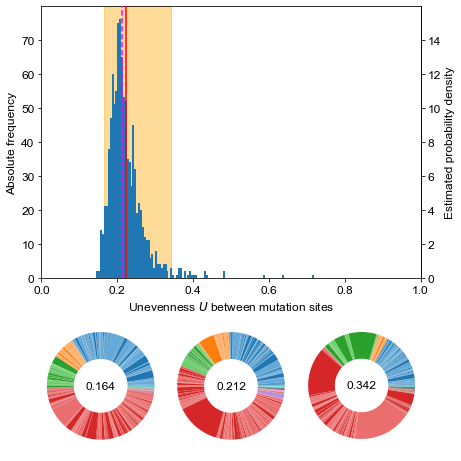

In [48]:
resolution = 200
meanstd = 0.95 # 95% span

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[0:-1, :])

histogram(ax, M, meanstd = meanstd, resolution=resolution)
qtls = [(1-meanstd)/2, 0.5, (1+meanstd)/2]

for i, qtl in enumerate(qtls):
    ax = fig.add_subplot(gs[-1, i])
    drawpies(ax, array=A, Us=M, qtl=qtl, decimals=3)

### SAVING
name = "Fig6.pdf"
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 7

In [ ]:
# Parameters
resolution = 11 #201 in the article
ns = [1, 10, 100] # values of n to simulate
nametag = "XXX"

In [ ]:
# Run the numerical experiment successively with n in ns (it can take a lot of time!)
n = 1
rmax = 25 * n
rs = np.arange(rmax) + n
logNsigmas = 10 ** np.linspace(-1, 2, resolution)

M = np.zeros((len(logNsigmas), 3))
M[:,0] = logNsigmas
for i, logNsigma in enumerate(logNsigmas):
    A = rng.lognormal(mean=logNmu, sigma=logNsigma, size=(1000000,rmax) ) # dims: (10**6, rmax)
    B = np.sum(rng.lognormal(mean=logNmu, sigma=logNsigma, size=(1000000,n) ), axis=-1)
    for j, r in enumerate(rs):
        C = np.sum(A[:,:r], axis=1) # dims: (10**6)
        if np.mean(C < B) < 0.05:
            M[i,1] = r / n
        elif i == rmax:
            M[i,1] = r + 1
        if np.median(C < B) < 0.05:
            M[i,2] = r / n
        elif i == rmax:
            M[i,2] = r + 1
        if np.prod(M[i,:]) != 0:
            break
    print(np.around((i+1)/len(logNsigmas), 2), end="\r") # print progression of the computation

np.savetxt("Inversion{}_{}.csv".format(n, nametag), M, delimiter=",")

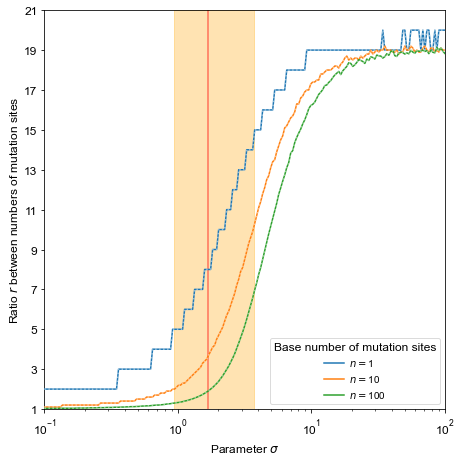

In [53]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[:, :])

# draw each curve corresponding to a value for n
for n in ns:
    M = np.genfromtxt("Inversion{}.csv".format(n), delimiter=',')
    ax.plot(M[:,0], M[:,1], zorder=3, label=r"$n =${}".format(n))#, c="red")
    ax.plot(M[:,0], M[:,2], zorder=3, alpha=0.5, c="w", ls="dotted")
# draw the calibrated range for param sigma
ax.axvspan(0.93, 3.73, color="orange", alpha=0.3, zorder=1)
ax.axvline(1.69, color="r", alpha=0.5, zorder=2)

ax.legend(title="Base number of mutation sites", loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, handlelength=2, handletextpad=0.5)
ax.set_xscale("log")
ax.set_xlim(logNsigmas[0], logNsigmas[-1])
ax.set_ylim(1, 21)
ax.set_yticks([1,3,5,7,9,11,13,15,17,19,21])
ax.set_xlabel(r"Parameter $\sigma$")
ax.set_ylabel("Ratio $r$ between numbers of mutation sites")

### SAVING
name = "Fig7.pdf"
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 8

In [ ]:
# Parameters
s = 10**2 # nb of samples for sets of mutation rates; in the article: 10**6
ms = [2, 20, 200, 2000] # nb of mutation sites in total
Xstds = [10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5] # range of values of the CV to test
avg = 1 # mean of the log-normal DMR

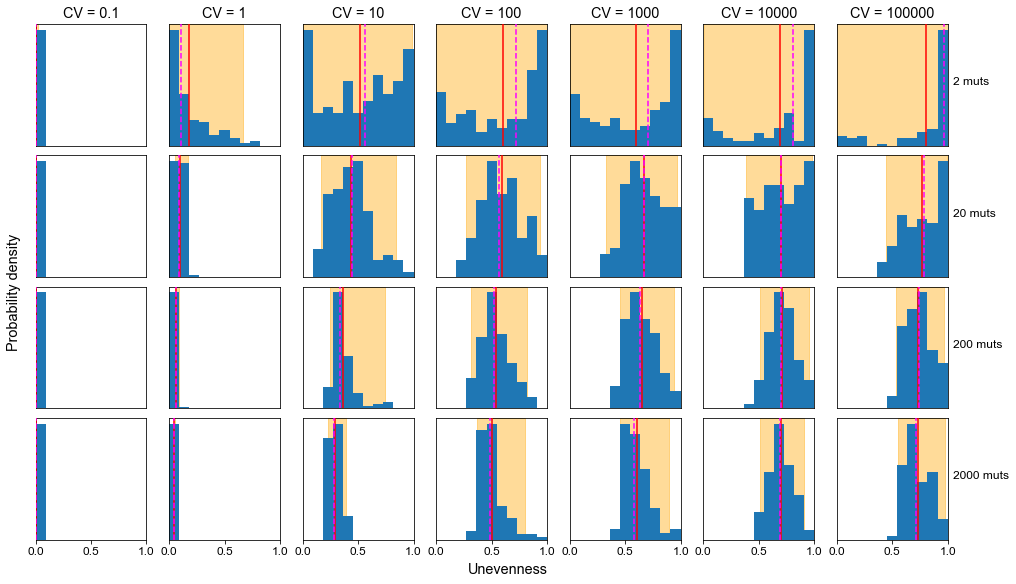

In [54]:
# Computation and graph
fig = plt.figure(constrained_layout=True, figsize=(len(Xstds)*2, len(ms)*2))
gs = fig.add_gridspec(len(ms), len(Xstds), wspace=0, hspace=0)

for i, m in enumerate(ms):
    stds = np.abs(avg) * np.array(Xstds)
    for j, std in enumerate(stds):
        logNmu = np.log(avg**2 / np.sqrt(std**2 + avg**2))
        logNsigma = np.sqrt(np.log((std**2 + avg**2) / avg**2))
# Computation and graphing
        A = rng.lognormal(mean=logNmu, sigma=logNsigma, size=(s,m) ) # all samples and all mutation rates (m,n)
        M = U(A)
        ax = fig.add_subplot(gs[i, j])
        histogram(ax, M, resolution=resolution, xlabel=False, ylabel=False, rightlabel=False, legend=False)
# Graphic settings
        if i == 0:
            ax.set_title("CV = {}".format(Xstds[j]))
        if j == len(stds) - 1:
            ax.text(1.05, 0.5, "{} muts".format(m), transform=ax.transAxes, size=12)
        if i != len(ms) - 1:
            ax.xaxis.set_ticks([])
        else:
            ax.xaxis.set_ticks([0, 0.5, 1])
        ax.yaxis.set_ticks([])
        print(np.around((i * len(stds) + j) / (len(stds) * len(ms)), 2), end="\r") # print computing progression

fig.supxlabel("Unevenness")
fig.supylabel("Probability density")

### SAVING
name = "Fig8.pdf"
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 9

In [58]:
# Parameters of the log-normal DMR
logNmu = -25.20
logNsigma = 1.72
sample = rng.lognormal(mean=logNmu, sigma=logNsigma, size=(10**3, 5000) ) # in the article: (10**6, 5000)
k = 1.5 # lim for x-axis

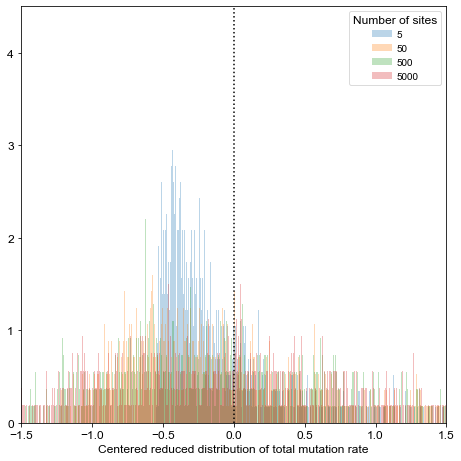

In [59]:
# Graph
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[:, :])

for i, nb in enumerate([5, 50, 500, 5000]):
    spl = np.sum(sample[:, :nb], axis=1)
    M = (spl - np.mean(spl)) / np.std(spl)
    n, bins, rects = ax.hist(M, bins=500, range=(-k, k), alpha=0.3, label="{}".format(nb), zorder=2, density=True)
ax.axvline(0, c="k", ls="dotted")

ax.legend(title="Number of sites", loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, handlelength=2, handletextpad=0.5)
ax.set_xlim(-k, k)
ax.set_ylim(0, 3*np.max(n))
ax.set_xlabel("Centered reduced distribution of total mutation rate")

### SAVING
name = "Fig9.pdf"
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

# Supplementary figures

In [3]:
def Gini(A, N=None): # Gini coefficient
    # from matrix A(x1,x2,...,y), compute D-1-matrix M(x1,x2,...)
    # of Gini indices of A along the xs distributions of ys
    # Input boolean N (x1,x2,...) where A is nonzero
    # to compute Gini with observed elements and not the known total number of elements
    M = np.zeros(A.shape[:-1])
    if N is None:
        N = A.shape[-1]
        for i in np.arange(A.shape[-1] - 1):
            M += np.sum(np.abs(A[...,i,None] - A[...,i+1:]), axis = len(A.shape)-1)
    else:
        for i in np.arange(A.shape[-1] - 1):
            M += np.sum( (A[...,i,None]!=0)*(A[...,i+1:]!=0) * np.abs(A[...,i,None] - A[...,i+1:]), axis = len(A.shape)-1)
    return M / (N * np.sum(A, axis=len(A.shape)-1))


def SLS2(A): # Summed share of the 2 most common
    # from matrix A(x1,x2,...,y), compute D-1-matrix M(x1,x2,...)
    # of SS2MC of A along the xs distributions of ys
    #
    # Indices of 2 most common shares
    if len(A.shape) == 1:
        A = A[None,:]
    I = A.argsort()[..., -2:]
    M = A[range(A.shape[0]),I[...,0]] + A[range(A.shape[0]),I[...,1]]
    N = np.sum(A, axis = len(A.shape)-1)
    return M / N

## Fig. 10

In [ ]:
# Repeat this cell with the desired number of mutations
nelms = np.array([5], dtype=np.int16) # for 5 mutations
nstps = 100
y = 10**3

G = np.zeros((nstps, y))
S = np.zeros((nstps, y))

for i in range(y):
    A = setupMPCs(nelms=nelms, nstps=nstps)[:,0,:]
    G[:,i] = Gini(A)
    S[:,i] = SLS2(A)

F = [lambda x: np.mean(x,            axis=-1),
     lambda x: np.median(x,          axis=-1),
     lambda x: np.quantile(x, 0.025, axis=-1),
     lambda x: np.quantile(x, 0.975, axis=-1)
    ]

GG = np.zeros((nstps, len(F)))
SS = np.zeros((nstps, len(F)))

for i, func in enumerate(F):
    GG[:,i] = func(G)
    SS[:,i] = func(S)

# Record results into specific G5, G10 etc.
G5 = GG
S5 = SS

In [ ]:
Gs = [G5, G10, G50]
Ss = [S5, S10, S50]
lss = ["dotted", "dashed", "solid"]

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(1, 1)

xs = np.array(range(nstps)) / nstps
ax = fig.add_subplot(gs[0, 0])
ax.axhline(1-1/5, color="grey", linestyle="dotted", zorder=0)
ax.axhline(1-1/10, color="grey", linestyle="dotted", zorder=0)
ax.axhline(1-1/50, color="grey", linestyle="dotted", zorder=0)
for i in range(len(Gs)):
    GG = Gs[i]
    SS = Ss[i]
    ax.fill_between(xs, GG[:,2], GG[:,3], color="r", alpha=0.1, zorder=2)
    ax.plot(xs, GG[:,0], c="r", linestyle=lss[i], zorder=4, label="{} mutations".format([5, 10, 50][i]))
    ax.fill_between(xs, SS[:,2], SS[:,3], color="b", alpha=0.1, zorder=1)
    ax.plot(xs, SS[:,0], c="b", linestyle=lss[i], zorder=3)

ax.set_xlabel(r"Unevenness $U$")
ax.set_ylabel(r"Gini coefficient $G$ (red)")
secax = ax.secondary_yaxis("right")
secax.set_ylabel("Sum of the two largest shares $SLS2$ (blue)")
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.legend(loc='best', fontsize='small', fancybox=True, framealpha=0.7, handlelength=2, handletextpad=0.5)

### SAVING
name = "Fig10.pdf"
plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 11

In [13]:
logNmu = -25.20
logNsigma = 1.72

# Gammak given that the CV is the same, as defined by log10CV
Gammatheta = (np.exp(logNsigma**2) - 1) * np.exp(logNmu + logNsigma**2 / 2)
Gammak = 1 / (np.exp(logNsigma**2) - 1)
print(Gammak, Gammatheta)

0.054743167890122416 9.117116997432397e-10


In [14]:
from scipy.stats import lognorm
from scipy.stats import gamma

def PDFlognorm(ax, mu=0, sigma=1.0, xmax=4.5, legend=True, log=True):
    x = np.linspace(lognorm.ppf(0, s=sigma, scale = np.exp(mu)), lognorm.ppf(0.999, s=sigma, scale = np.exp(mu)), 10**6)
    y = lognorm.pdf(x, s=sigma, scale = np.exp(mu) )
    ax.plot(x, y)
    ax.set_xlabel("Potential mutation rate")
    ax.set_ylabel("Lognormal probability density")
    ax.set_ylim(0,np.max(y)*1.1)
    if log:
        ax.set_xscale("log")
    else:
        ax.set_xlim(0,xmax)
    if legend:
    # create a list with two empty handles (or more if needed)
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
    # create the corresponding number of labels (= the text you want to display)
        labels = []
        labels.append(r"$\mu$ = {}".format(np.around(mu, 3)))
        labels.append(r"$\sigma$ = {}".format(np.around(sigma, 3)))
    # create the legend, supressing the blank space of the empty line symbol and the
    # padding between symbol and label by setting handlelenght and handletextpad
        ax.legend(handles, labels, loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

def PDFgamma(ax, k=0, theta=1.0, xmax=4.5, legend=True, log=True):
    x = np.linspace(gamma.ppf(0, a=k, scale=theta), gamma.ppf(0.999, a=k, scale=theta), 1000)
    y = gamma.pdf(x, a=k, scale=theta)
    ax.plot(x, y)
    ax.set_xlabel("Potential mutation rate")
    ax.set_ylabel("Gamma probability density")
    ax.set_ylim(0, np.max(np.isfinite(y))*1.1)
    if log:
        ax.set_xscale("log")
    else:
        ax.set_xlim(0,xmax)
    if legend:
    # create a list with two empty handles (or more if needed)
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
    # create the corresponding number of labels (= the text you want to display)
        labels = []
        labels.append(r"$k$ = {}".format(np.around(k, 3)))
        labels.append(r"$\theta$ = {}".format(np.around(theta, 3)))
    # create the legend, supressing the blank space of the empty line symbol and the
    # padding between symbol and label by setting handlelenght and handletextpad
        ax.legend(handles, labels, loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

In [16]:
def histogram(ax, M, resolution=200, interv=(0,1), meanstd=0.95, c="orange", alpha=1,
              xlabel=True, ylabel=True, rightlabel=True, legend=False, label=None):
    n, bins, patches = ax.hist(M, bins=resolution, range=interv, alpha=alpha, label=label, zorder=2)
    if not meanstd is None:
        ax.axvline(x=np.mean(M), c="r", linestyle="solid", zorder=3)
        ax.axvline(x=np.median(M), c="magenta", linestyle="--", zorder=4)
        ax.axvspan(np.quantile(M, (1-meanstd)/2), np.quantile(M, (1+meanstd)/2), color="orange", alpha=0.4, zorder=1)
#        ax.axvline(x=np.quantile(M, (1-meanstd)/2), linestyle="--", c=c)
#        ax.axvline(x=np.quantile(M, (1+meanstd)/2), linestyle="--", c=c)
    if xlabel:
#        ax.set_xlabel("Gini coefficient of mutation sites")
        ax.set_xlabel(r"Unevenness $U$ between mutation sites")
#        ax.set_xlabel("Gini coefficient (blue) or Shannon (orange) index of mutation sites")
    if ylabel:
        ax.set_ylabel("Absolute frequency")
    if rightlabel:
        secax = ax.secondary_yaxis('right', functions=(lambda x: x * resolution / s, lambda x: x * s / resolution))
        secax.set_ylabel("Estimated probability density")
    if legend:
    # create a list with two empty handles (or more if needed)
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
    # create the corresponding number of labels (= the text you want to display)
        labels = []
        labels.append(r"$\mu$ = {}".format(np.around(mu, 3)))
        labels.append(r"$\sigma$ = {}".format(np.around(sigma, 3)))
    # create the legend, supressing the blank space of the empty line symbol and the
    # padding between symbol and label by setting handlelenght and handletextpad
        ax.legend(handles, labels, loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
    ax.set_xlim(interv)
    return n

In [23]:
setup = [1, 1, 9, 1, 1, 2, 1, 1, 2, 1, 20, 1,]
g = len(setup) # nb of genes
m = sum(setup) # nb of mutation sites in total
s = 10**3 # nb of samples for sets of mutation rates

A = rng.lognormal(mean=logNmu, sigma=logNsigma, size=(s,m) ) # all samples and all mutation rates (m,n)
M2 = U(A)
A = rng.gamma(shape=Gammak, scale=Gammatheta, size=(s,m) ) # all samples and all mutation rates (m,n)
N2 = U(A)

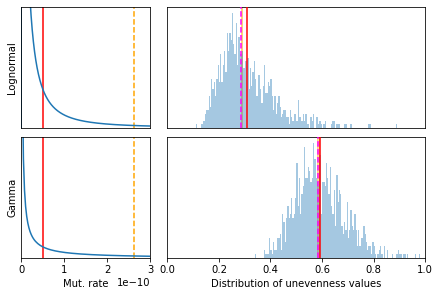

In [24]:
xmax = 3*10**-10 # lim for the proba distributions
meanstd = 0.025
resolution = 200

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)

# LOG-NORMAL
ax1 = fig.add_subplot(gs[0, 0])
ax1.axvline(x=np.exp(logNmu + logNsigma**2 /2), c="r")
ax1.axvline(x=np.exp(logNmu + logNsigma**2 /2) + np.sqrt((np.exp(logNsigma**2)-1) * np.exp(2*logNmu + logNsigma**2)), c="orange", ls="dashed")
PDFlognorm(ax1, mu=logNmu, sigma=logNsigma, xmax=xmax, log=False, legend=False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_ticks([])
ax1.set_ylim(0, 10**10)
ax1.set_ylabel("Lognormal")

ax2 = fig.add_subplot(gs[0, 1:])
m2 = histogram(ax2, M2, meanstd = meanstd, resolution=resolution, c="orange", alpha=0.4, label="Shannon", xlabel=False, ylabel=False, rightlabel=False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

# GAMMA
ax3 = fig.add_subplot(gs[1, 0])
ax3.axvline(x=Gammak * Gammatheta, c="r")
ax3.axvline(x=Gammak * Gammatheta + np.sqrt(Gammak * Gammatheta**2), c="orange", ls="dashed")
x = np.linspace(gamma.ppf(0, a=Gammak, scale=Gammatheta), gamma.ppf(0.999, a=Gammak, scale=Gammatheta), 1000)
y = gamma.pdf(x, a=Gammak, scale=Gammatheta)
ax3.plot(x, y)
ax3.set_xlabel("Mut. rate")
ax3.set_xlim(0, xmax)
ax3.set_ylim(0, 10**10)
ax3.get_yaxis().set_ticks([])
ax3.set_ylabel("Gamma")

ax4 = fig.add_subplot(gs[1, 1:])
n2 = histogram(ax4, N2, meanstd = meanstd, resolution=resolution, c="orange", alpha=0.4, label="Shannon", xlabel=False, ylabel=False, rightlabel=False)
ax4.set_xlabel("Distribution of unevenness values")
ax4.get_yaxis().set_ticks([])

### SAVING
name = "Fig11.pdf"
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 12

In [61]:
# nb sites for each gene in the setup
s = 3 # nb setups
g = 5 # nb genes/pathways
o = 1000 # nb of observations in an experiment = obs. span
x = 1000 # nb of experiments replicated
nametag = "5bis"
Utarget = 0.074 # U for the MPC in the middle panel

Utarget = np.array([Utarget])
nelms = np.array([g], dtype=np.int16)
setup = np.ones((s,g), dtype=np.half)
setup[1] = setupMPCs(nelms, 1, targets=Utarget, metric=U)[:,0,:]
setup[2] = 0
setup[2,0] = np.sum(setup[1]) - np.min(setup[1])
setup[2,1] = np.min(setup[1])

In [48]:
# SCALE to attribute each mutation to a gene
# = cumulated expected values for each gene, dims: (s, g)
scale = np.cumsum(setup, axis=1) / np.sum(setup, axis=1)[:,None]

stcnt = np.zeros((s, o), dtype=np.intc)
np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

In [49]:
# Matrix of completion experiment results
rslts = np.zeros((s, x)) # matrix to be filled
stcnt = np.zeros((s, x, o, g), dtype=np.intc) # site counts
# Updating rule
filtr = np.reshape(np.argmax(rng.uniform(size =(s, x, o))[:,:,:,None] < scale[:,None,None,:], axis=-1), (s,x,o))
# filter for stcnt, dims: (s, x, o, g) -> (s, x, o)
stcnt[np.tile(np.arange(s)[:,None,None], (1, x, o)),
      np.tile(np.arange(x)[None,:,None], (s, 1, o)),
      np.tile(np.arange(o)[None,None,:], (s, x, 1)),
      filtr] += 1
stcnt = np.cumsum(stcnt, axis=2) # dims: (s', x', o, g)
stcnt[np.tile((setup == 0)[:,None,None,:], (1,x,o,1))] = 1 # avoiding being counted as not-found when appearance is impossible
news = np.argmax(np.all(stcnt > 0, axis = -1) > 0, axis=-1) # reuse filtr for the total number to hit them all for each x, dims: (s, x)
rslts[news>0] = news[news>0]
if np.min(rslts) == 0:
    print("Uncompleted experiment(s) detected: increase observation span.")
else:
    xmax = np.max(rslts, axis=1)
    print("The longest experiments collected {} observations.".format(xmax))
    stcnt = np.count_nonzero(rslts[:,:,None] == (np.arange(o)+1)[None,None,:], axis=1)
    np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

The longest experiments collected [47. 76. 89.] observations.


In [50]:
counts = np.genfromtxt("CountsMPC{}.csv".format(nametag), delimiter=',').T
xs = np.array(range(counts.shape[1])) + 2
xmax = len(xs) - 2
nruns = np.sum(counts[0,:])

In [51]:
# Graphing parameters
scaling = 2 # scale / 10^scaling
xlim = 100 # lim of the x-axis
quantiles = [0.5, 0.025, 0.975] # drawinglines for median and 95% range
qts = np.zeros(len(quantiles))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20

N = 9 # organizing the layout of the figure
n = 1

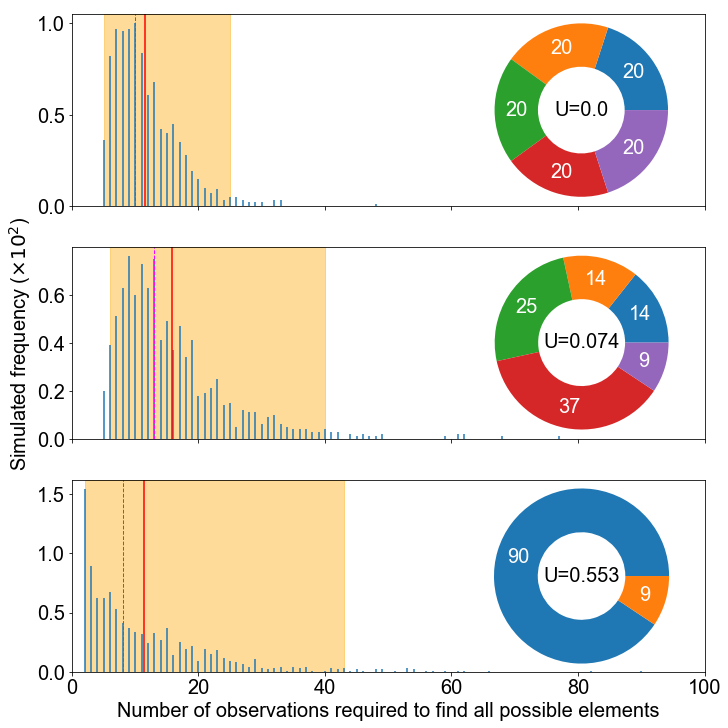

In [53]:
# Graph
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3*(N+n)-n, 5)

ax = fig.add_subplot(gs[:,:])
ax.tick_params(colors="None", top=False, bottom=False, left=False, right=False)
ax.set_xlabel("Number of observations required to find all possible elements")
ax.set_ylabel(r"Simulated frequency ($\times 10^{}$)".format(scaling) if scaling > 1 else r"Simulated frequency")
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

# Plotting each subfigure top to bottom
for i in range(3):
# Completion experiments
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, :])
    avgcount = np.sum(counts[i,:] * xs) / np.sum(counts[i,:]) # average count
    for j, qt in enumerate(quantiles): # quantiles
        qts[j] = (xs[np.nonzero( np.cumsum(counts[i,:]) > np.floor(nruns*qt) )][0]
                + xs[np.nonzero( np.cumsum(counts[i,:]) > np.ceil(nruns*qt) )][0]) / 2
    ax.axvline(x=avgcount, c="r")
    ax.axvline(x=qts[0], linestyle="dashed", c="magenta", linewidth=1,)
    ax.axvspan(qts[1], qts[2], color="orange", alpha=0.4, zorder=0)
    ax.vlines(xs, np.zeros(xs.shape), counts[i,:] / 10**scaling, zorder=2) # drawing the distribution of completion experiment results
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_ylim(0, np.max(counts[i,:] / 10**scaling) * 1.05)
    plt.xlim(0, xlim)
    if i < 2:
        plt.setp(ax.get_xticklabels(), visible=False)
# MPC of the setup-array
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, -2:])
    ax.pie(setup[i], startangle=00, shadow=False,
           colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',],
           autopct=lambda x: "" if np.around(x, 0) < 3 else np.around(np.array(x, dtype=np.intc), 1),
           pctdistance = 0.75, normalize=True, wedgeprops=dict(width=0.5), textprops = dict(color ="w"))
    ax.text(0., 0., "U={}".format(np.around(U(setup[i]), 3)), horizontalalignment='center', verticalalignment='center')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

### SAVING
name = "Fig12.pdf".format(nametag)
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 13

In [62]:
# nb sites for each gene in the setup
s = 3 # nb setups
g = 16 # nb genes/pathways
o = 10000 # nb of observations in an experiment = obs. span
x = 1000 # nb of experiments replicated
nametag = "16bis"
Utarget = np.array([0.211, 0.211, 0.211]) # U for the MPC in the middle panel

nelms = np.array([g], dtype=np.int16)
setup = setupMPCs(nelms, s, targets=Utarget, metric=U)[:,0,:]

In [63]:
# SCALE to attribute each mutation to a gene
# = cumulated expected values for each gene, dims: (s, g)
scale = np.cumsum(setup, axis=1) / np.sum(setup, axis=1)[:,None]

stcnt = np.zeros((s, o), dtype=np.intc)
np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

In [64]:
# Matrix of completion experiment results
rslts = np.zeros((s, x)) # matrix to be filled
stcnt = np.zeros((s, x, o, g), dtype=np.intc) # site counts
# Updating rule
filtr = np.reshape(np.argmax(rng.uniform(size =(s, x, o))[:,:,:,None] < scale[:,None,None,:], axis=-1), (s,x,o))
# filter for stcnt, dims: (s, x, o, g) -> (s, x, o)
stcnt[np.tile(np.arange(s)[:,None,None], (1, x, o)),
      np.tile(np.arange(x)[None,:,None], (s, 1, o)),
      np.tile(np.arange(o)[None,None,:], (s, x, 1)),
      filtr] += 1
stcnt = np.cumsum(stcnt, axis=2) # dims: (s', x', o, g)
stcnt[np.tile((setup == 0)[:,None,None,:], (1,x,o,1))] = 1 # avoiding being counted as not-found when appearance is impossible
news = np.argmax(np.all(stcnt > 0, axis = -1) > 0, axis=-1) # reuse filtr for the total number to hit them all for each x, dims: (s, x)
rslts[news>0] = news[news>0]
if np.min(rslts) == 0:
    print("Uncompleted experiment(s) detected: increase observation span.")
else:
    xmax = np.max(rslts, axis=1)
    print("The longest experiments collected {} observations.".format(xmax))
    stcnt = np.count_nonzero(rslts[:,:,None] == (np.arange(o)+1)[None,None,:], axis=1)
    np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

The longest experiments collected [1169. 1183. 1384.] observations.


In [65]:
counts = np.genfromtxt("CountsMPC{}.csv".format(nametag), delimiter=',').T
xs = np.array(range(counts.shape[1])) + 2
xmax = len(xs) - 2
nruns = np.sum(counts[0,:])

In [68]:
# Graphing parameters
scaling = 2 # scale / 10^scaling
xlim = 2000 # lim of the x-axis
quantiles = [0.5, 0.025, 0.975] # drawinglines for median and 95% range
qts = np.zeros(len(quantiles))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20

N = 9 # organizing the layout of the figure
n = 1

In [ ]:
# Graph
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3*(N+n)-n, 5)

ax = fig.add_subplot(gs[:,:])
ax.tick_params(colors="None", top=False, bottom=False, left=False, right=False)
ax.set_xlabel("Number of observations required to find all possible elements")
ax.set_ylabel(r"Simulated frequency ($\times 10^{}$)".format(scaling) if scaling > 1 else r"Simulated frequency")
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

# Plotting each subfigure top to bottom
for i in range(3):
# Completion experiments
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, :])
    avgcount = np.sum(counts[i,:] * xs) / np.sum(counts[i,:]) # average count
    for j, qt in enumerate(quantiles): # quantiles
        qts[j] = (xs[np.nonzero( np.cumsum(counts[i,:]) > np.floor(nruns*qt) )][0]
                + xs[np.nonzero( np.cumsum(counts[i,:]) > np.ceil(nruns*qt) )][0]) / 2
    ax.axvline(x=avgcount, c="r")
    ax.axvline(x=qts[0], linestyle="dashed", c="magenta", linewidth=1,)
    ax.axvspan(qts[1], qts[2], color="orange", alpha=0.4, zorder=0)
    ax.vlines(xs, np.zeros(xs.shape), counts[i,:] / 10**scaling, zorder=2) # drawing the distribution of completion experiment results
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_ylim(0, np.max(counts[i,:] / 10**scaling) * 1.05)
    plt.xlim(0, xlim)
    if i < 2:
        plt.setp(ax.get_xticklabels(), visible=False)
# MPC of the setup-array
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, -2:])
    ax.pie(setup[i], startangle=00, shadow=False,
           colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',],
           autopct=lambda x: "" if np.around(x, 0) < 3 else np.around(np.array(x, dtype=np.intc), 1),
           pctdistance = 0.75, normalize=True, wedgeprops=dict(width=0.5), textprops = dict(color ="w"))
    ax.text(0., 0., "U={}".format(np.around(U(setup[i]), 3)), horizontalalignment='center', verticalalignment='center')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

### SAVING
name = "Fig13.pdf".format(nametag)
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()

## Fig. 14

In [70]:
# nb sites for each gene in the setup
s = 3 # nb setups
g = 16 # nb genes/pathways
o = 100000 # nb of observations in an experiment = obs. span
x = 1000 # nb of experiments replicated
nametag = "XXX"
Utarget = np.array([0.25, 0.50, 0.75]) # U for the MPC in the middle panel

nelms = np.array([g], dtype=np.int16)
setup = setupMPCs(nelms, s, targets=Utarget, metric=U)[:,0,:]

In [71]:
# SCALE to attribute each mutation to a gene
# = cumulated expected values for each gene, dims: (s, g)
scale = np.cumsum(setup, axis=1) / np.sum(setup, axis=1)[:,None]

stcnt = np.zeros((s, o), dtype=np.intc)
np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

In [72]:
# Matrix of completion experiment results
rslts = np.zeros((s, x)) # matrix to be filled
stcnt = np.zeros((s, x, o, g), dtype=np.intc) # site counts
# Updating rule
filtr = np.reshape(np.argmax(rng.uniform(size =(s, x, o))[:,:,:,None] < scale[:,None,None,:], axis=-1), (s,x,o))
# filter for stcnt, dims: (s, x, o, g) -> (s, x, o)
stcnt[np.tile(np.arange(s)[:,None,None], (1, x, o)),
      np.tile(np.arange(x)[None,:,None], (s, 1, o)),
      np.tile(np.arange(o)[None,None,:], (s, x, 1)),
      filtr] += 1
stcnt = np.cumsum(stcnt, axis=2) # dims: (s', x', o, g)
stcnt[np.tile((setup == 0)[:,None,None,:], (1,x,o,1))] = 1 # avoiding being counted as not-found when appearance is impossible
news = np.argmax(np.all(stcnt > 0, axis = -1) > 0, axis=-1) # reuse filtr for the total number to hit them all for each x, dims: (s, x)
rslts[news>0] = news[news>0]
if np.min(rslts) == 0:
    print("Uncompleted experiment(s) detected: increase observation span.")
else:
    xmax = np.max(rslts, axis=1)
    print("The longest experiments collected {} observations.".format(xmax))
    stcnt = np.count_nonzero(rslts[:,:,None] == (np.arange(o)+1)[None,None,:], axis=1)
    np.savetxt("CountsMPC{}.csv".format(nametag), stcnt.T, delimiter=",")

The longest experiments collected [  660.  3969. 13889.] observations.


In [74]:
counts = np.genfromtxt("CountsMPC{}.csv".format(nametag), delimiter=',').T
xs = np.array(range(counts.shape[1])) + 2
xmax = len(xs) - 2
nruns = np.sum(counts[0,:])

In [77]:
# Graphing parameters
scaling = 2 # scale / 10^scaling
xmin = 10 # lim of the x-axis
xmax = 100000
quantiles = [0.5, 0.025, 0.975] # drawinglines for median and 95% range
qts = np.zeros(len(quantiles))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20

N = 9 # organizing the layout of the figure
n = 1

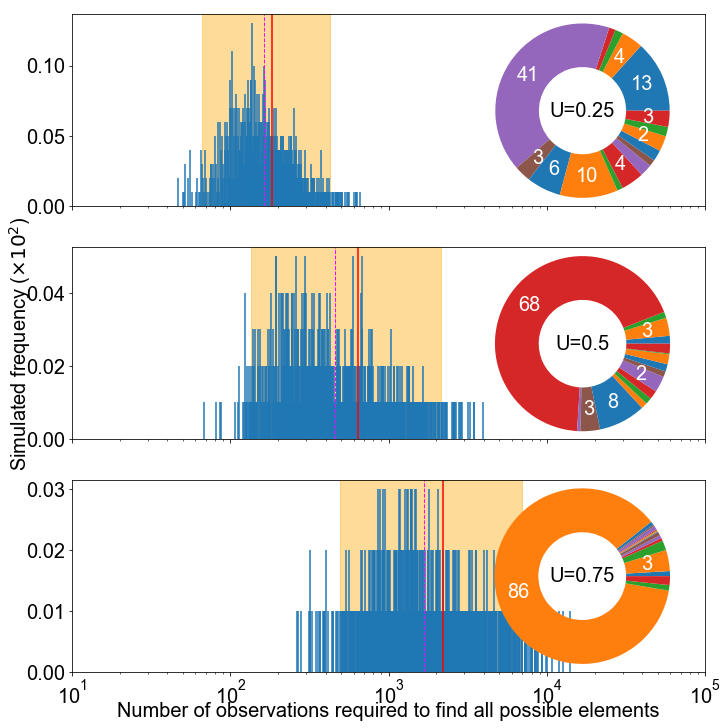

In [78]:
# Graph
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3*(N+n)-n, 5)

ax = fig.add_subplot(gs[:,:])
ax.tick_params(colors="None", top=False, bottom=False, left=False, right=False)
ax.set_xlabel("Number of observations required to find all possible elements")
ax.set_ylabel(r"Simulated frequency ($\times 10^{}$)".format(scaling) if scaling > 1 else r"Simulated frequency")
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

# Plotting each subfigure top to bottom
for i in range(3):
# Completion experiments
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, :])
    avgcount = np.sum(counts[i,:] * xs) / np.sum(counts[i,:]) # average count
    for j, qt in enumerate(quantiles): # quantiles
        qts[j] = (xs[np.nonzero( np.cumsum(counts[i,:]) > np.floor(nruns*qt) )][0]
                + xs[np.nonzero( np.cumsum(counts[i,:]) > np.ceil(nruns*qt) )][0]) / 2
    ax.axvline(x=avgcount, c="r")
    ax.axvline(x=qts[0], linestyle="dashed", c="magenta", linewidth=1,)
    ax.axvspan(qts[1], qts[2], color="orange", alpha=0.4, zorder=0)
    ax.vlines(xs, np.zeros(xs.shape), counts[i,:] / 10**scaling, zorder=2) # drawing the distribution of completion experiment results
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_ylim(0, np.max(counts[i,:] / 10**scaling) * 1.05)
    ax.set_xscale("log")
    plt.xlim(xmin, xmax)
    if i < 2:
        plt.setp(ax.get_xticklabels(), visible=False)
# MPC of the setup-array
    ax = fig.add_subplot(gs[i*(N+n):(i+1)*(N+n)-n, -2:])
    ax.pie(setup[i], startangle=00, shadow=False,
           colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',],
           autopct=lambda x: "" if np.around(x, 0) < 3 else np.around(np.array(x, dtype=np.intc), 1),
           pctdistance = 0.75, normalize=True, wedgeprops=dict(width=0.5), textprops = dict(color ="w"))
    ax.text(0., 0., "U={}".format(np.around(U(setup[i]), 3)), horizontalalignment='center', verticalalignment='center')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

### SAVING
name = "Fig14.pdf".format(nametag)
#plt.savefig(name, facecolor='w', edgecolor='w', transparent=False, bbox_inches="tight")
plt.show()